In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import cv2
import supervision as sv
import os

In [3]:
def pixel_accuracy(pred, target):
    correct = (pred == target).sum()
    total = pred.size
    return correct / total

def intersection_over_union(pred, target):
    intersection = (pred & target).sum()
    union = (pred | target).sum()
    return intersection / union

def dice_coefficient(pred, target):
    intersection = (pred & target).sum()
    return 2 * intersection / (pred.sum() + target.sum())



def calculate_metrics(pred_list, target_list):
    total_pixel_acc = 0
    total_iou = 0
    total_dice = 0
    n = len(pred_list)  # Assuming pred_list and target_list are of the same length

    for pred, target in zip(pred_list, target_list):
        total_pixel_acc += pixel_accuracy(pred, target)
        total_iou += intersection_over_union(pred, target)
        total_dice += dice_coefficient(pred, target)

    # Calculate the mean for each metric
    mean_pixel_acc = total_pixel_acc / n
    mean_iou = total_iou / n
    mean_dice = total_dice / n

    return mean_pixel_acc, mean_iou, mean_dice


def get_segmentation_mask_from_image(img, shape=(1920, 1080)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    masks = img > 0
    return masks
    


In [2]:

import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

def load_and_process_image(mask_path: str, original_mask_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Load and preprocess mask images."""
    mask = cv2.imread(mask_path)
    original_mask_img = cv2.imread(original_mask_path)
    
    # Resize logic
    if original_mask_img.shape[:2] != mask.shape[:2]:
        target_shape = (
            min(original_mask_img.shape[1], mask.shape[1]),
            min(original_mask_img.shape[0], mask.shape[0])
        )
        original_mask_img = cv2.resize(original_mask_img, target_shape[::-1])
        mask = cv2.resize(mask, target_shape[::-1])
    
    return mask, original_mask_img

# Define Erosion Function
def apply_erosion(image, kernel_size=(5, 5), iterations=1):
    """
    Apply erosion to an image using a specified kernel size and number of iterations.
    
    Parameters:
    - image: The input image on which erosion will be applied.
    - kernel_size: The size of the kernel to be used for erosion.
    - iterations: The number of times erosion is applied.
    
    Returns:
    - eroded_image: The eroded image.
    ""
    
    """
    est = cv2.getStructuringElement(cv2.MORPH_ERODE, kernel_size)
    eroded_image = cv2.erode(image, est, iterations=iterations)
    return eroded_image


def erode_all_masks(masks: List[np.ndarray], kernel_size=(5, 5), iterations=1) -> List[np.ndarray]:
    """Apply erosion to all masks."""
    return [apply_erosion(mask, kernel_size, iterations) for mask in masks]

def apply_dilation(image, kernel_size=(5, 5), iterations=1):
    """
    Apply dilation to an image using a specified kernel size and number of iterations.
    
    Parameters:
    - image: The input image on which dilation will be applied.
    - kernel_size: The size of the kernel to be used for dilation.
    - iterations: The number of times dilation is applied.
    
    Returns:
    - dilated_image: The dilated image.
    ""
    
    """
    est = cv2.getStructuringElement(cv2.MORPH_DILATE, kernel_size)
    dilated_image = cv2.dilate(image, est, iterations=iterations)
    return dilated_image

def dilate_all_masks(masks: List[np.ndarray], kernel_size=(5, 5), iterations=1) -> List[np.ndarray]:
    """Apply dilation to all masks."""
    return [apply_dilation(mask, kernel_size, iterations) for mask in masks]


def apply_opening(image, kernel_size=(5, 5), iterations=1):
    """
    Apply opening to an image using a specified kernel size and number of iterations.
    
    Parameters:
    - image: The input image on which opening will be applied.
    - kernel_size: The size of the kernel to be used for opening.
    - iterations: The number of times opening is applied.
    
    Returns:
    - opened_image: The opened image.
    ""
    
    """
    est = cv2.getStructuringElement(cv2.MORPH_OPEN, kernel_size)
    opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, est, iterations=iterations)
    return opened_image

def open_all_masks(masks: List[np.ndarray], kernel_size=(5, 5), iterations=1) -> List[np.ndarray]:
    """Apply opening to all masks."""
    return [apply_opening(mask, kernel_size, iterations) for mask in masks]

def apply_closing(image, kernel_size=(5, 5), iterations=1):
    """
    Apply closing to an image using a specified kernel size and number of iterations.
    
    Parameters:
    - image: The input image on which closing will be applied.
    - kernel_size: The size of the kernel to be used for closing.
    - iterations: The number of times closing is applied.
    
    Returns:
    - closed_image: The closed image.
    ""
    
    """
    est = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, est, iterations=iterations)
    return closed_image

def close_all_masks(masks: List[np.ndarray], kernel_size=(5, 5), iterations=1) -> List[np.ndarray]:
    """Apply closing to all masks."""
    return [apply_closing(mask, kernel_size, iterations) for mask in masks]



def plot_mask_operations(mask_file: str, experiment_path: str, masks: List[np.ndarray], mask_files: List[str]):
    
    # Find the index of the mask file
    index = mask_files.index(mask_file)
    # Load original not masked image
    original_image_path = os.path.join(experiment_path, "original", mask_file)
    original_image = cv2.imread(original_image_path)

    # Load the original image
    original_image_path_masked = os.path.join(experiment_path, "masked", mask_file)
    original_image_masked = cv2.imread(original_image_path_masked)
    
    # Get the corresponding mask
    mask = masks[index]
    
    # Plot the original image and apply every defined operation and plot them
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # Plot original image
    axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'Original Image\n{mask_file}')
    axes[0].axis('off')

    # Plot original mask
    axes[1].imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Original Mask\n{mask_file}')
    axes[1].axis('off')

    # Apply erosion and plot
    eroded_mask = apply_erosion(mask, kernel_size=(9, 9), iterations=1)
    axes[2].imshow(cv2.cvtColor(eroded_mask, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Eroded Mask')
    axes[2].axis('off')

    # Apply dilation and plot
    dilated_mask = apply_dilation(mask, kernel_size=(9, 9), iterations=1)
    axes[3].imshow(cv2.cvtColor(dilated_mask, cv2.COLOR_BGR2RGB))
    axes[3].set_title('Dilated Mask')
    axes[3].axis('off')

    # Apply opening and plot
    opened_mask = apply_opening(mask, kernel_size=(9, 9), iterations=1)
    axes[4].imshow(cv2.cvtColor(opened_mask, cv2.COLOR_BGR2RGB))
    axes[4].set_title('Opened Mask')
    axes[4].axis('off')

    # Apply closing and plot
    closed_mask = apply_closing(mask, kernel_size=(9, 9), iterations=1)
    axes[5].imshow(cv2.cvtColor(closed_mask, cv2.COLOR_BGR2RGB))
    axes[5].set_title('Closed Mask')
    axes[5].axis('off')

    plt.tight_layout()
    plt.show()



In [5]:

# Set paths
sessoes_folder = "./sessoes"
original_mask_folder = 'pad_segmentation_all/all-mask'

#get masked images from "sessoe/group_1-manual-lapsal-group_1-Vinicius_Moraes"
experiment_path = "sessoes/sam-336e2l-group_2-João_Felipe_Gobeti_Calenzani"
mask_path = os.path.join(experiment_path, "masked")
original_mask_path = "pad_segmentation_all/all-mask"


sample_files = os.listdir(mask_path)

#load images
masks = []
mask_files = []
original_masks = []
for file in sample_files:
    mask = cv2.imread(os.path.join(mask_path, file))
    original_mask = cv2.imread(os.path.join(original_mask_path, (file[:-4] + "_segmentation.png")))
    masks.append(mask)
    mask_files.append(file)
    original_masks.append(original_mask)



#for every eroded mask, check if size is equal to original mask, resize both to the minimum size
for i in range(len(masks)):
    if original_masks[i].shape[:2] != masks[i].shape[:2]:
        target_shape = (
            min(original_masks[i].shape[1], masks[i].shape[1]),
            min(original_masks[i].shape[0], masks[i].shape[0])
        )
        original_masks[i] = cv2.resize(original_masks[i], target_shape[::-1])
        masks[i] = cv2.resize(masks[i], target_shape[::-1])



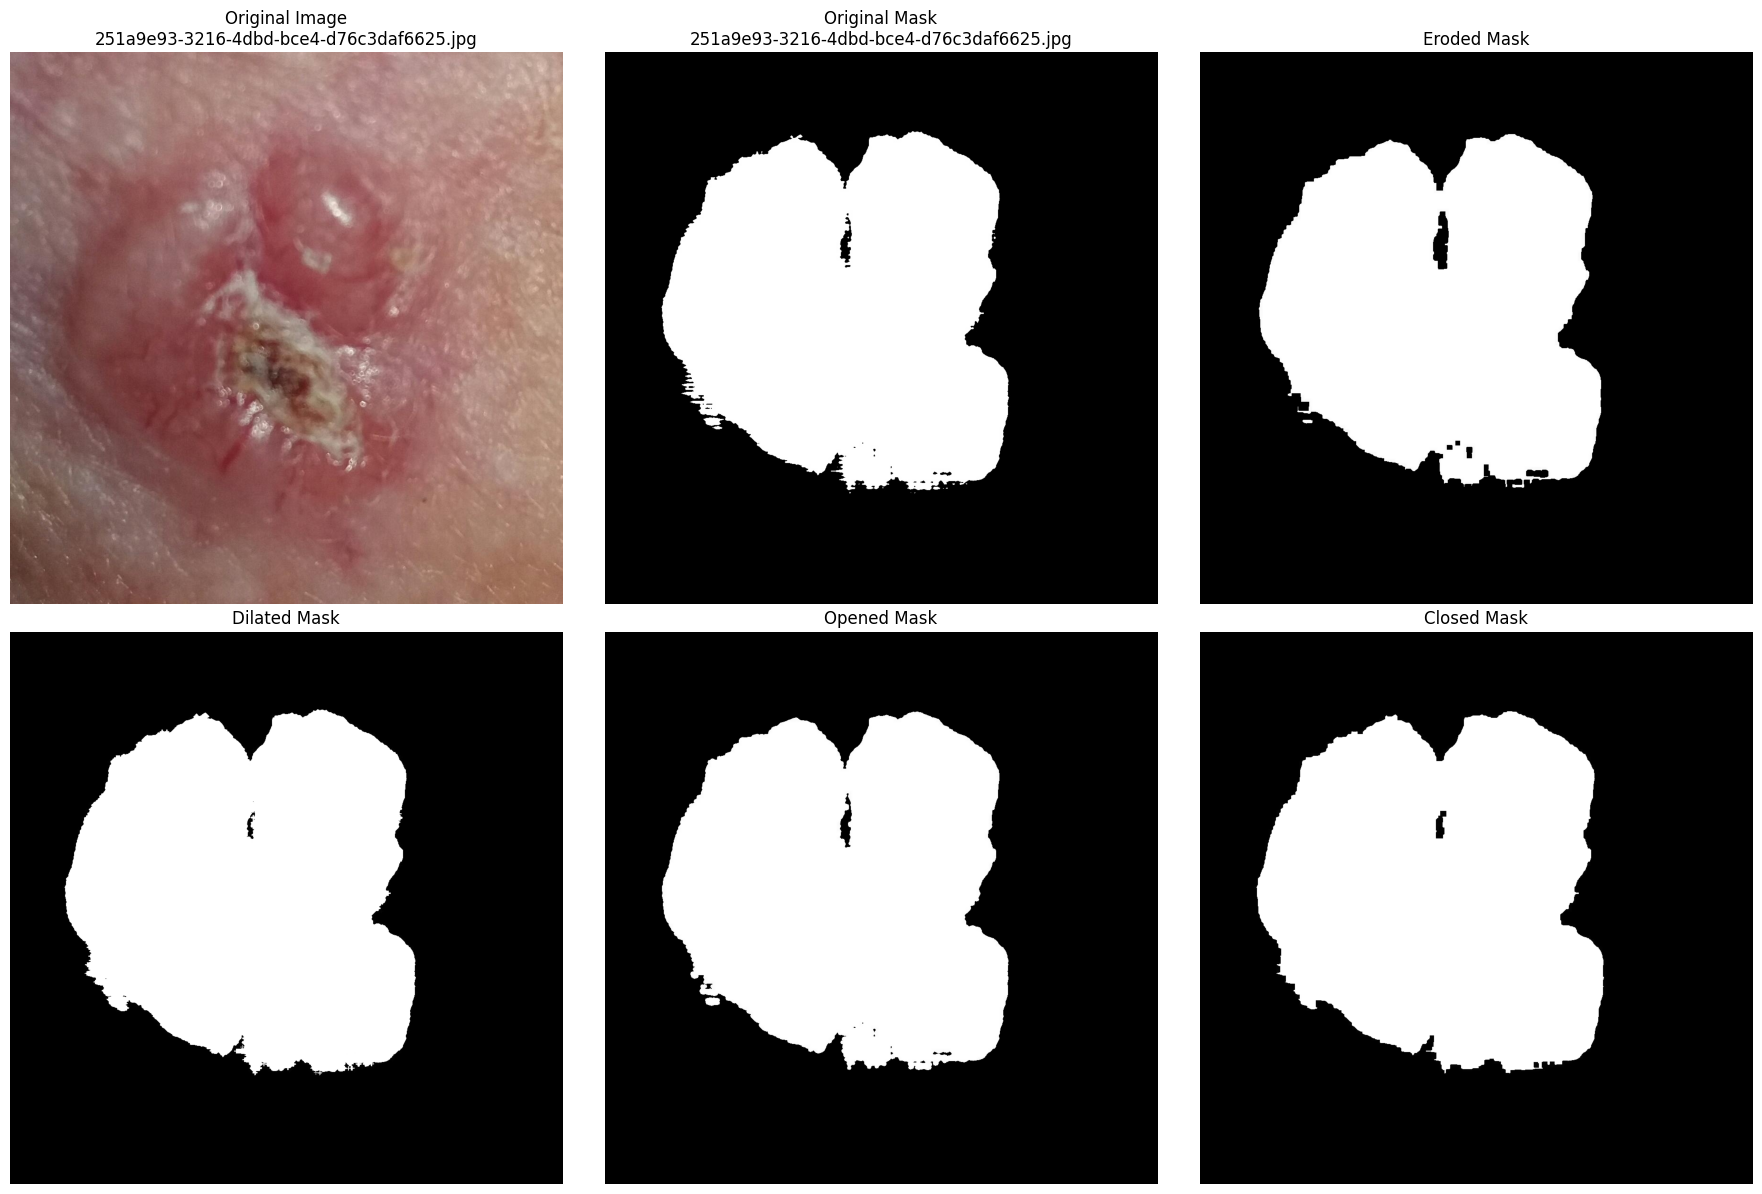

In [6]:
plot_mask_operations(mask_files[0], experiment_path=experiment_path, masks=masks, mask_files=mask_files)


In [20]:
#This operation takes time and the results are stored in a csv file
# # Set paths
# sessoes_folder = "./sessoes"
# original_mask_folder = 'pad_segmentation_all/all-mask'

# # Collect metrics
# metrics_df, groups_data = collect_metrics(sessoes_folder, original_mask_folder)



In [7]:
#save   
# metrics_df.to_csv('metrics_df.csv', index=False)
#read 
metrics_df = pd.read_csv('metrics_df.csv')
metrics_df.head()

,group,type,version,pixel_accuracy,iou,dice,time
0,group_2,manual,original,0.884036,0.766283,0.867679,604.131
1,group_2,manual,eroded,0.866008,0.744922,0.853817,604.131
2,group_2,manual,dilated,0.892960,0.781096,0.877096,604.131
3,group_2,manual,opened,0.877416,0.765911,0.867440,604.131
4,group_2,manual,closed,0.887952,0.766541,0.867844,604.131


In [8]:
# Group by 'group', 'type', and 'version' and aggregate the metrics
aggregated_metrics = metrics_df.groupby(['group', 'type', 'version']).agg({
    'iou': ['mean', 'std'],
    'dice': ['mean', 'std'],
    'time': ['mean', 'std']
}).reset_index()

# Rename columns for better readability
aggregated_metrics.columns = [
    'group', 'type', 'version',
    'iou_mean', 'iou_std',
    'dice_mean', 'dice_std',
    'time_mean', 'time_std'
]

aggregated_metrics.head()

,group,type,version,iou_mean,iou_std,dice_mean,dice_std,time_mean,time_std
0,group_1,manual,closed,0.719992,0.161127,0.825549,0.125885,504.460182,232.517458
1,group_1,manual,dilated,0.704776,0.164807,0.814399,0.130044,504.460182,232.517458
2,group_1,manual,eroded,0.735761,0.154357,0.837268,0.119515,504.460182,232.517458
3,group_1,manual,opened,0.720729,0.160882,0.826094,0.125635,504.460182,232.517458
4,group_1,manual,original,0.720303,0.161018,0.825780,0.125778,504.460182,232.517458


In [ ]:
def display_metrics_table(aggregated_metrics):
    # Create pivot table
    table_data = pd.pivot_table(
        aggregated_metrics,
        index=['group', 'version'],
        columns=['type'],
        values=['iou_mean', 'dice_mean']
    ).round(3)
    
    def highlight_max(s):
        # Check if series is part of a group by checking the index level
        is_max = pd.Series(data=False, index=s.index)
        # Get group values and find max for each group
        for name, group in s.groupby(level=0):
            is_max[group.index] = group == group.max()
        return ['background-color: #246906' if v else '' for v in is_max]
    
    # Create styled version of the table
    styled_table = table_data.style\
        .format('{:.3f}')\
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('text-align', 'center'),
                ('font-weight', 'bold'),
            ]},
            {'selector': 'td', 'props': [
                ('text-align', 'center')
            ]}
        ])\
        .set_caption('Performance Metrics by Group and Version')\
        .apply(highlight_max)

    display(styled_table)
display_metrics_table(aggregated_metrics)

In [26]:
#set every group as the same 
aggregated_metrics_same_group = aggregated_metrics.copy()
aggregated_metrics_same_group['group'] = 'all'
display_metrics_table(aggregated_metrics_same_group)

Erosion improves the manual masks whereas dilation improve sam masks metrics. 